# Training Bidirectional LSTM With Attention

In [ ]:
import pandas as pd
import numpy as np
import string

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from sklearn.model_selection import train_test_split
import re
import os

#### Import cleaned data

In [ ]:
!wget https://raw.githubusercontent.com/AdiShirsath/Neural-Machine-Translation/master/Data/cleaned.csv

--2022-01-21 17:05:29--  https://raw.githubusercontent.com/AdiShirsath/Neural-Machine-Translation/master/Data/cleaned.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3959978 (3.8M) [text/plain]
Saving to: ‘cleaned.csv’

cleaned.csv         100%[===================>]   3.78M  --.-KB/s    in 0.08s   

2022-01-21 17:05:29 (46.1 MB/s) - ‘cleaned.csv’ saved [3959978/3959978]



In [ ]:
!wget https://raw.githubusercontent.com/TejasGadi/Transliteration_model/main/transliteration_cleaned.csv

--2022-01-21 17:05:30--  https://raw.githubusercontent.com/TejasGadi/Transliteration_model/main/transliteration_cleaned.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2660202 (2.5M) [text/plain]
Saving to: ‘transliteration_cleaned.csv’

transliteration_cle 100%[===================>]   2.54M  --.-KB/s    in 0.08s   

2022-01-21 17:05:30 (32.6 MB/s) - ‘transliteration_cleaned.csv’ saved [2660202/2660202]



In [ ]:
df = pd.read_csv("/content/transliteration_cleaned.csv")

In [ ]:
df.tail()

,Unnamed: 0,English,Marathi
9934,9994,paramparik drushy varnapatatil durbinine aajas...,पारंपरिक दृश्य वर्णपटातील दुर्बिणीने आकाशात पा...
9935,9995,ketkar he swataha bhagawdgeeteche abhyasak aan...,केतकर हे स्वतः भगवद्‌गीतेचे अभ्यासक आणि उपासक ...
9936,9996,antarctica ha jagatalya konatyahi any walavant...,अंटार्क्टिका हा जगातल्या कोणत्याही अन्य वाळवंट...
9937,9997,baudh ha zilha bharatachya odisha rajyatil ek ...,बौध जिल्हा हा भारताच्या ओडिशा राज्यातील एक जिल...
9938,9998,pawasamule samana ushira suru zala,पावसामुळले सामना उशीरा सुरू झाला.


**Note-** this dataset was cleaned in notebook1 [here](https://github.com/AdiShirsath/Neural-Machine-Translation/blob/master/EDA_And_Cleaning_Text.ipynb)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9939 entries, 0 to 9938
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  9939 non-null   int64 
 1   English     9939 non-null   object
 2   Marathi     9939 non-null   object
dtypes: int64(1), object(2)
memory usage: 233.1+ KB


### Add start and end tokens to target sentecnes
* This helps model understand when sentence is started and ended
* Beause of this decoder can handle diff length sentence than encoder

In [ ]:
df['Marathi'] =df.Marathi.apply(lambda x: 'sos '+ x + ' eos')

In [ ]:
df.head()

,Unnamed: 0,English,Marathi
0,0,abhyasakanna marathicha pahila shilalekh sapad...,sos अभ्यासकांना मराठीचा पहिला शिलालेख सापडला त...
1,1,tya sanstheche te vyavasthapakiya sanchalak hote.,sos त्या संस्थेचे ते व्यवस्थापकीय संचालक होते....
2,2,dhobi kivva parit ha baara balutedaranpaiki ek...,sos धोबी किंवा परीट हा बारा बलुतेदारांपैकी एक ...
3,3,shivarayanchi gupt khalbate yethech chalat.,sos शिवरायांची गुप्त खलबते येथेच चालत. eos
4,4,netaji palkar yanchi samadhi taamsa (taluka. h...,sos नेताजी पालकर यांची समाधी तामसा (तालुका .हद...


##### Convert to list for tokenizer

In [ ]:
eng_texts = df.English.to_list()
mar_texts = df.Marathi.to_list()

## Tokenizer
* Converting into numbers

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
def tokenize_sent(text):
  '''
  Take list on texts as input and 
  returns its tokenizer and enocded text
  '''
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(text)

  return tokenizer, tokenizer.texts_to_sequences(text)



In [ ]:
# Tokenize english and marathi sentences
eng_tokenizer, eng_encoded= tokenize_sent(text= eng_texts)
mar_tokenizer, mar_encoded= tokenize_sent(text= mar_texts)

#### English

In [ ]:
eng_encoded[100:105]

[[10015, 113, 10016, 10017, 958, 497, 6, 10018, 5653, 1],
 [4, 3938, 560, 137, 5, 278, 106, 10019, 5654, 1979, 682, 5655],
 [3935, 5, 1463, 63, 10020, 1056, 498, 153, 10021, 127, 959, 10022, 88, 65],
 [214, 3939, 182, 39, 1451, 683, 3940],
 [4, 51, 3020, 1057, 729, 92, 1]]

In [ ]:
eng_index_word = eng_tokenizer.index_word
eng_word_indec= eng_tokenizer.word_index


### Get vocab size which will be needed next

In [ ]:
ENG_VOCAB_SIZE = len(eng_tokenizer.word_counts)+1
ENG_VOCAB_SIZE

34464

#### Mrathi

In [ ]:
mar_encoded[30000:30005]

[]

In [ ]:
mar_index_word = mar_tokenizer.index_word
mar_word_index= mar_tokenizer.word_index


In [ ]:
MAR_VOCAB_SIZE=len(mar_tokenizer.word_counts)+1
MAR_VOCAB_SIZE

31071

In [ ]:
max_eng_len = 0
for i in range(len(eng_encoded)):
  if len(eng_encoded[i]) > max_eng_len:
    max_eng_len= len(eng_encoded[i])

max_mar_len = 0
for i in range(len(mar_encoded)):
  if len(eng_encoded[i]) > max_mar_len:
    max_mar_len= len(mar_encoded[i])


In [ ]:
print(max_eng_len)
max_mar_len

118


119

## Padding
* Making input sentences as max length of input sentence with padding zero
* Same for target make them as max length of target sentence.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
eng_padded = pad_sequences(eng_encoded, maxlen=max_eng_len, padding='post')
mar_padded = pad_sequences(mar_encoded, maxlen=max_mar_len, padding='post')


In [ ]:
eng_padded

array([[ 9775,  5552,   172, ...,     0,     0,     0],
       [   20,  1281,    11, ...,     0,     0,     0],
       [ 3883,   113,  2369, ...,     0,     0,     0],
       ...,
       [ 1144,     8,  9292, ...,     0,     0,     0],
       [34461,     8,  1954, ...,     0,     0,     0],
       [34462,  1673, 34463, ...,     0,     0,     0]], dtype=int32)

In [ ]:
mar_padded.shape

(9939, 119)

##### Converting to array

In [ ]:
eng_padded= np.array(eng_padded)
mar_padded= np.array(mar_padded)

## Train test split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(eng_padded, mar_padded, test_size=0.1, random_state=0)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8945, 118), (994, 118), (8945, 119), (994, 119))

## Building Model 

In [ ]:
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Concatenate, Dropout
from tensorflow.keras import Input, Model

In [ ]:
### Import attention layer

In [ ]:
!wget https://raw.githubusercontent.com/TejasGadi/Neural-Machine-Translation/master/Attention_model/BahdanauAttention.py

--2022-01-21 17:05:32--  https://raw.githubusercontent.com/TejasGadi/Neural-Machine-Translation/master/Attention_model/BahdanauAttention.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5425 (5.3K) [text/plain]
Saving to: ‘BahdanauAttention.py’

BahdanauAttention.p 100%[===================>]   5.30K  --.-KB/s    in 0s      

2022-01-21 17:05:32 (64.8 MB/s) - ‘BahdanauAttention.py’ saved [5425/5425]



In [ ]:
from keras.layers import Activation, dot

In [ ]:
# Encoder 

encoder_inputs = Input(shape=(max_eng_len,)) 
enc_emb = Embedding(ENG_VOCAB_SIZE, 1024)(encoder_inputs)

# Bidirectional lstm layer
enc_lstm1 = Bidirectional(LSTM(256,return_sequences=True,return_state=True))
encoder_outputs1, forw_state_h, forw_state_c, back_state_h, back_state_c = enc_lstm1(enc_emb)

final_enc_h = Concatenate()([forw_state_h,back_state_h])
final_enc_c = Concatenate()([forw_state_c,back_state_c])

encoder_states =[final_enc_h, final_enc_c]

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(MAR_VOCAB_SIZE, 1024) 
dec_emb = dec_emb_layer(decoder_inputs)
#LSTM using encoder_states as initial state
decoder_lstm = LSTM(512, return_sequences=True, return_state=True) 
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

#Attention Layer
# attention_layer = AttentionLayer()
# attention_result, attention_weights = attention_layer([encoder_outputs1, decoder_outputs])

attention = dot([decoder_outputs,encoder_outputs1], axes=[2, 2])
# The softmax function  gives the probability distribution which can used as attention weights
attention = Activation('sigmoid', name='attention')(attention)
# pre attention weight and encoder as a dot product to give context
context = dot([attention, encoder_outputs1], axes=[2,1])

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, context])

#Dense layer
decoder_dense = Dense(MAR_VOCAB_SIZE, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)


# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 118)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 118, 1024)    35291136    ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 bidirectional (Bidirectional)  [(None, 118, 512),   2623488     ['embedding[0][0]']              
                                 (None, 256),                                                 

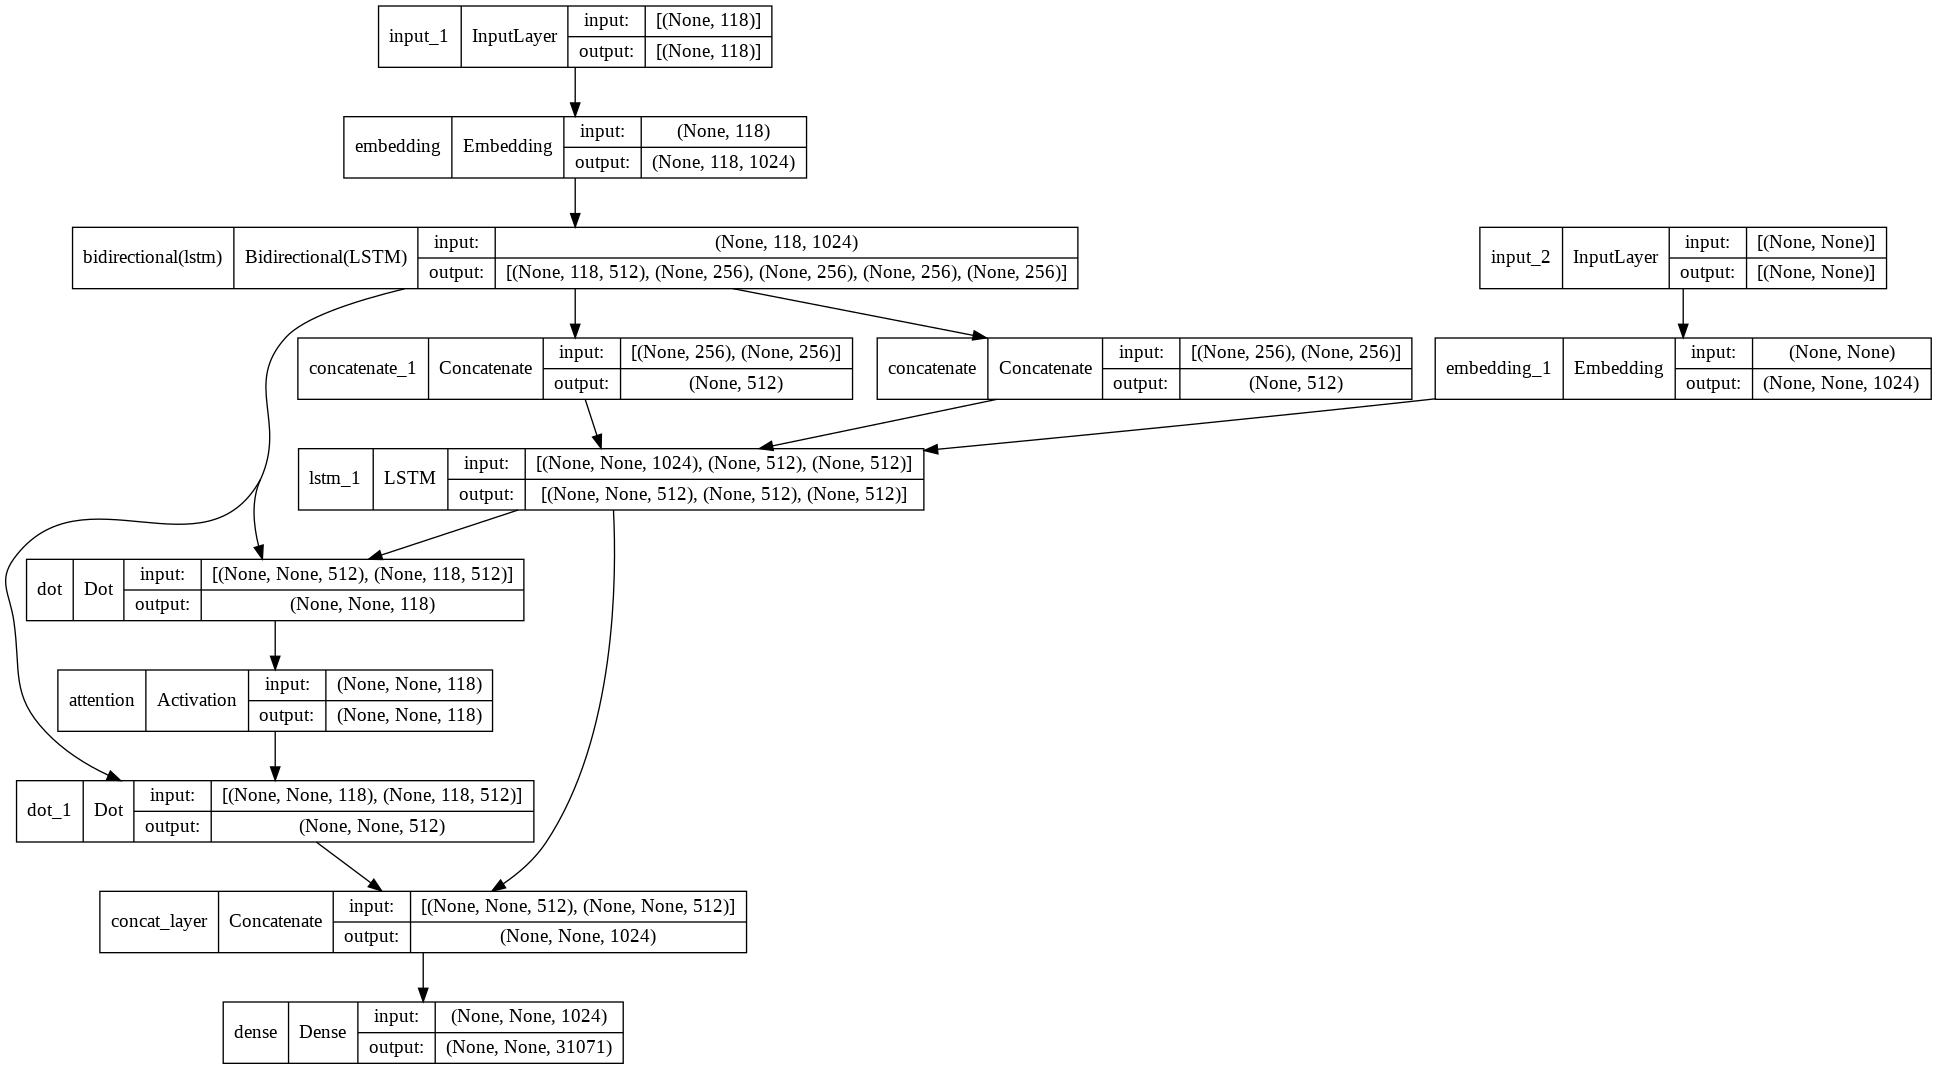

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

***IMP note :- if loss categorical crossentropy used then shapes incompatible error will occcur beause we have to use sparse_categorical_crossentropy when we have all different labels categorical is for mutliclass labels***

In [ ]:
# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Define callbacks

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("/content/model1/", monitor='val_accuracy')

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

callbacks_list = [checkpoint, early_stopping]

In [ ]:
# Training
encoder_input_data = X_train
# To make same as target data skip last number which is just padding
decoder_input_data = y_train[:,:-1]
# Decoder target data has to be one step ahead so we are taking from 1 as told in keras docs
decoder_target_data =  y_train[:,1:]

# Testing
encoder_input_test = X_test
decoder_input_test = y_test[:,:-1]
decoder_target_test=  y_test[:,1:]

In [ ]:
EPOCHS= 20 #@param {type:'slider',min:10,max:100, step:10 }

In [ ]:
history = model.fit([encoder_input_data, decoder_input_data],decoder_target_data, 
                    epochs=4, 
                    batch_size=32,
                    validation_data = ([encoder_input_test, decoder_input_test],decoder_target_test)
                    )

Epoch 1/4
280/280 [==============================] - 192s 687ms/step - loss: 0.1915 - accuracy: 0.9607 - val_loss: 0.7136 - val_accuracy: 0.9339
Epoch 2/4
280/280 [==============================] - 191s 682ms/step - loss: 0.1346 - accuracy: 0.9705 - val_loss: 0.7177 - val_accuracy: 0.9354
Epoch 3/4
280/280 [==============================] - 191s 682ms/step - loss: 0.0896 - accuracy: 0.9792 - val_loss: 0.7323 - val_accuracy: 0.9356
Epoch 4/4
280/280 [==============================] - 192s 685ms/step - loss: 0.0572 - accuracy: 0.9862 - val_loss: 0.7494 - val_accuracy: 0.9363


#### Saving weights is very important if ypu dont after colab session ends you might have to retrain model 

In [ ]:
model.save("/content/model2.h5")

#### After saving weight you can restart colab session without GPU 
Create model and
load model

In [ ]:
# model2=tensorflow.keras.models.load_model("/content/saved_model/model1.h5")

## Inference model
* For prediction we have to do this was because we trained encoder on input and decoder on target differently so we'll have to do same for prediction

In [ ]:
encoder_model = Model(encoder_inputs, outputs = [encoder_outputs1, final_enc_h, final_enc_c])

decoder_state_h = Input(shape=(512,))
decoder_state_c = Input(shape=(512,))
decoder_hidden_state_input = Input(shape=(118,512))

dec_states = [decoder_state_h, decoder_state_c]

dec_emb2 = dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=dec_states)

dec_states2=[state_h2,state_c2]
# Attention inference
# attention_result_inf, attention_weights_inf = attention_layer([decoder_outputs2,decoder_hidden_state_input])

attention = dot([decoder_outputs2,decoder_hidden_state_input], axes=[2, 2])
# The softmax function  gives the probability distribution which can used as attention weights
attention = Activation('sigmoid', name='attention')(attention)
# pre attention weight and encoder as a dot product to give context
attention_result_inf = dot([attention,decoder_hidden_state_input], axes=[2,1])

decoder_concat_input_inf = Concatenate(axis=-1, name='concat_layer')([decoder_outputs2, attention_result_inf])

# dec_states2= [state_h2, state_c2]

decoder_outputs2 = decoder_dense(decoder_concat_input_inf)

decoder_model= Model(
                    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_h, decoder_state_c],
                     [decoder_outputs2]+ dec_states2)

### Model will predict numbers and word at time so we'll have to convert them to words of language 

In [ ]:
def get_predicted_sentence(input_seq):
    # Encode the input as state vectors.
    enc_output, enc_h, enc_c = encoder_model.predict(input_seq)
  
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = mar_word_index['sos']
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [enc_output, enc_h, enc_c ])
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index == 0:
          break
        else:
            # convert max index number to marathi word
            sampled_char = mar_index_word[sampled_token_index]

        if (sampled_char!='end'):
            # aapend it ti decoded sent
            decoded_sentence += ' '+sampled_char
        
        # Exit condition: either hit max length or find stop token.
        if (sampled_char == 'eos' or len(decoded_sentence.split()) >= 36):
            stop_condition = True
        
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        # Update states
        enc_h, enc_c = h, c
    
    return decoded_sentence

## Converting x and y back to words-sentences

In [ ]:
def get_marathi_sentence(input_sequence):
    sentence =''
    for i in input_sequence:
      if i!=0 :
        sentence =sentence +mar_index_word[i]+' '
    return sentence 

def get_english_sentence(input_sequence):
    sentence =''
    for i in input_sequence:
      if i!=0:
        sentence =sentence +eng_index_word[i]+' '
    return sentence     

# Model results

In [ ]:
len(X_test)

994

#### Using simple loop we will take random 15 numbers from x_test and get results


In [ ]:
for i in np.random.randint(10, 800, size=15):
  print("English Sentence:",get_english_sentence(X_test[i]))
  print("Actual Marathi Sentence:",get_marathi_sentence(y_test[i])[4:-4])
  # Before passing input it has to be reshape as following
  print("Predicted Marathi Translation:",get_predicted_sentence(X_test[i].reshape(1,118))[:-4])
  print("----------------------------------------------------------------------------------------")

English Sentence: ram tyachi samjut kadhun tyalahi ushti bore khayala sangatat 
Actual Marathi Sentence: राम त्याची समजूत काढून त्यालाही उष्टी बोरे खायला सांगतात 
Predicted Marathi Translation:  त्याची त्याची लसूण आणि त्याची लसूण त्रास दूर करते
----------------------------------------------------------------------------------------
English Sentence: sadanand chendavankar 
Actual Marathi Sentence: सदानंद चेंदवणकर 
Predicted Marathi Translation:  श्री
----------------------------------------------------------------------------------------
English Sentence: ya 22 pratignya manavata va bauddha dharmat mahatvachya ahet 
Actual Marathi Sentence: या २२ प्रतिज्ञा मानवता व बौद्ध धर्मात महत्त्वाच्या आहेत 
Predicted Marathi Translation:  या महत्वाच्या व जैन व जैन यांवर पृथ्वी व आठ आठ आहेत
----------------------------------------------------------------------------------------
English Sentence: joshi sevanivrutta hotil 
Actual Marathi Sentence: जोशी सेवानिवृत्त होतील 
Predicted Marathi Translation